In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

### Default settings

In [3]:
np.random.seed(0)
%matplotlib inline
sns.set_style('darkgrid')


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [5]:
META_PATH = "D:/ML_work/10_foods/meta/"
IMG_FILE_PATH = "D:/ML_work/10_foods/images/"

In [10]:
### Temp delete later


META_PATH="D:/ML_work/10_foods/meta/"
import pandas as pd
classes = pd.read_csv(META_PATH+'classes.txt', header=None,names=['Food'])
labels = pd.read_csv(META_PATH+'labels.txt', header=None,names=['Food'])
print(classes)
#print(type(labels))
class_to_norminal = dict(zip(classes["Food"].values, range(classes.shape[0])))
#print(class_to_norminal)
#print(type(class_to_norminal))

             Food
0       apple_pie
1  baby_back_ribs
2    caesar_salad
3    deviled_eggs
4   eggs_benedict
5         falafel
6    garlic_bread
7       hamburger
8       ice_cream
9         waffles


### Read from txt file and filter for selected classes

In [14]:
classes_needed = ['apple_pie',
'baby_back_ribs',
'caesar_salad',
'deviled_eggs',
'eggs_benedict',
'falafel',
'garlic_bread',
'hamburger',
'ice_cream',
'waffles']

train_df = pd.read_csv(META_PATH+'train.txt', header=None,names=['Img'])
valid_df = pd.read_csv(META_PATH+'test.txt', header=None,names=['Img'])

def starts_with_any(word, word_list):
    return any(word.startswith(x) for x in word_list)

# Apply the function to the 'Food' column and filter the DataFrame
matched_rows = train_df['Img'].apply(lambda x: starts_with_any(x, classes_needed))

# Extract the 'Food' column values where condition is True
train_list = train_df['Img'][matched_rows].tolist()

# Apply the function to the 'Food' column and filter the DataFrame
matched_rows = valid_df['Img'].apply(lambda x: starts_with_any(x, classes_needed))

# Extract the 'Food' column values where condition is True
test_list = valid_df['Img'][matched_rows].tolist()


In [15]:
classes = pd.read_csv(META_PATH+'classes.txt', header=None)
labels = pd.read_csv(META_PATH+'labels.txt', header=None)
class_to_norminal = dict(zip(classes[0].values, range(classes.shape[0])))

train_df = pd.DataFrame(train_list, columns=['txt'])
train_df['img'] = train_df['txt'].apply(lambda x : x+'.jpg')
train_df['label'] = train_df['txt'].apply(lambda x: class_to_norminal[x.split('/')[0]])

train_df.drop(['txt'], axis=1, inplace=True)
train_df = train_df.sample(frac=1)

valid_df = pd.DataFrame(test_list, columns=['txt'])
valid_df['img'] = valid_df['txt'].apply(lambda x: x+'.jpg')
valid_df['label'] = valid_df['txt'].apply(lambda x: class_to_norminal[x.split('/')[0]])

valid_df.drop(['txt'], axis=1, inplace=True)
valid_df = valid_df.sample(frac=1)
         
print(f'train_data: {train_df.shape}')
print(f'valid_data: {valid_df.shape}')

train_data: (7500, 2)
valid_data: (2500, 2)


In [16]:
train_dg = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        shear_range=0.3,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.25,
)

valid_dg = ImageDataGenerator(
        rescale=1./255,
)

In [17]:
BATCH_SIZE = 64
IMAGE_SIZE = 224

train_data = train_dg.flow_from_dataframe(
    dataframe=train_df,
    directory=IMG_FILE_PATH,
    x_col="img",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=True,
)
valid_data = valid_dg.flow_from_dataframe(
    dataframe=valid_df,
    directory=IMG_FILE_PATH,
    x_col="img",
    y_col="label",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    shuffle=True,
)

Found 7500 validated image filenames.
Found 2500 validated image filenames.


C:\Users\vinee\AppData\Local\Temp\ipykernel_5924\4223854982.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


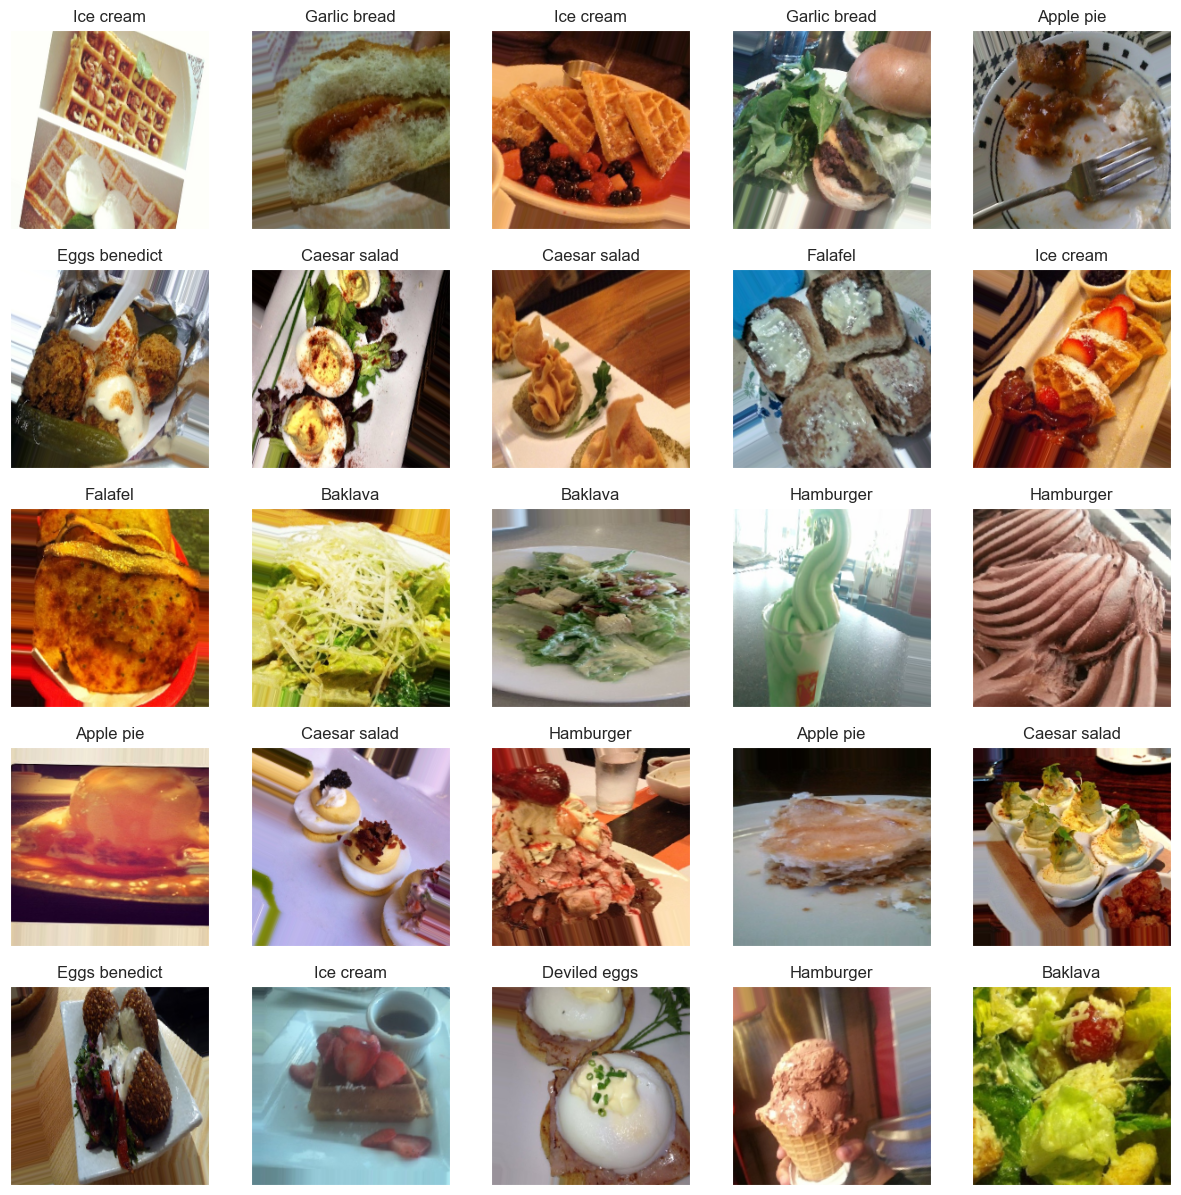

In [18]:
x, y = next(train_data)
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15))

for i in range(5):
    for j in range(5):
        ax[i][j].imshow(x[i+j*5])
        ax[i][j].set_title(labels[0][y[i+j*5]])
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        
fig.show()

In [44]:
classes = pd.read_csv('cla_full.txt', header=None)

In [19]:
pre_trained = keras.applications.MobileNetV3Large(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')
pre_trained.trainable = True

In [20]:
model = keras.Sequential([
    pre_trained,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(101, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               123008    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 101)               13029     
                                                                 
Total params: 3132389 (11.95 MB)
Trainable params: 31079

In [21]:
EPOCHS=20

# callbacks
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',patience = 1,verbose = 1)
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience = 5,verbose = 1,restore_best_weights = True)
chkp = keras.callbacks.ModelCheckpoint('mobilenet_v3_large_checkpoint.h5',monitor='val_accuracy',verbose=1,save_best_only=True)

with tf.device('/GPU:0'):
    hist = model.fit(
        train_data,
        validation_data = valid_data,
        epochs = EPOCHS,
        callbacks=[early_stop, reduce_lr, chkp],
    )

model.save('mobilenet_v3_large_final.h5')

Epoch 1/20
118/118 [==============================] - ETA: 0s - loss: 1.4108 - accuracy: 0.5951
Epoch 1: val_accuracy improved from -inf to 0.10000, saving model to mobilenet_v3_large_checkpoint.h5


C:\Users\vinee\miniconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


118/118 [==============================] - 689s 6s/step - loss: 1.4108 - accuracy: 0.5951 - val_loss: 2.8522 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/20
118/118 [==============================] - ETA: 0s - loss: 0.6522 - accuracy: 0.8092
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 2: val_accuracy did not improve from 0.10000
118/118 [==============================] - 617s 5s/step - loss: 0.6522 - accuracy: 0.8092 - val_loss: 3.5368 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/20
118/118 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.8775
Epoch 3: val_accuracy improved from 0.10000 to 0.10880, saving model to mobilenet_v3_large_checkpoint.h5
118/118 [==============================] - 555s 5s/step - loss: 0.4158 - accuracy: 0.8775 - val_loss: 3.4592 - val_accuracy: 0.1088 - lr: 1.0000e-04
Epoch 4/20
118/118 [==============================] - ETA: 0s - loss: 0.3265 - accuracy: 0.8988
Epoch 4: ReduceLROnPlateau reducing lea

## Load Model

In [33]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image

In [34]:
from keras.models import load_model
model = load_model('mobilenet_v3_large_final.h5')

In [35]:
nutrient=pd.read_csv("FoodCalDB.csv",index_col=0)
n_dict=nutrient.T.to_dict('list')

In [54]:
import json
def load_image(img_input, show=False):
    img_path="D:/ML_work/sample/"+img_input+".jpg"
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()
    
    pred=model.predict(img_tensor)
    bestMatch=(pred.argmax(axis=1))[0]
    classlist=classes.values.tolist()
    foodFound=classlist[bestMatch]
    print(foodFound)
    nutrient=n_dict[foodFound[0]]
    print(nutrient)
    #return foodFound
    json_string = json.dumps({'name':foodFound[0],
                    'unit':nutrient[0],
                    'qty':nutrient[1],
                     'calorie':nutrient[2],
                   'fat':nutrient[3],
                   'carb':nutrient[4],
                   'protein':nutrient[5]})
    return json_string

In [58]:
print(load_image('asdasfs'))

1/1 [==============================] - 0s 57ms/step
['caesar_salad']
['grams', 100.0, 158, 13.0, 7.5, 3.3]
{"name": "caesar_salad", "unit": "grams", "qty": 100.0, "calorie": 158, "fat": 13.0, "carb": 7.5, "protein": 3.3}
